 Sleep Stage Classification - LightGBM

In [6]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ======================
# 1. Paths & Data Load
# ======================
BASE_PATH = Path().resolve().parents[2]
DATASETS_PATH = BASE_PATH / "datalake" / "data-for-model"

TRAINING_DATA_FILE = DATASETS_PATH / "train" / "train_sleep_cassette.parquet"
VALIDATION_DATA_FILE = DATASETS_PATH / "val" / "val_sleep_cassette.parquet"
TEST_DATA_FILE = DATASETS_PATH / "test" / "test_sleep_cassette.parquet"

df_train = pd.read_parquet(TRAINING_DATA_FILE, engine="fastparquet")
df_val = pd.read_parquet(VALIDATION_DATA_FILE, engine="fastparquet")
df_test = pd.read_parquet(TEST_DATA_FILE, engine="fastparquet")

print("Train:", df_train.shape, "Val:", df_val.shape, "Test:", df_test.shape)

Train: (98128, 59) Val: (36215, 59) Test: (26798, 59)


In [11]:
# ======================
# 2. Separar X e y
# ======================
target = "stage"
drop_cols = ["subject_id", "night_id", "sex", target]

X_train, y_train = df_train.drop(columns=drop_cols, errors="ignore"), df_train[target]
X_val, y_val     = df_val.drop(columns=drop_cols, errors="ignore"), df_val[target]
X_test, y_test   = df_test.drop(columns=drop_cols, errors="ignore"), df_test[target]

# ======================
# 3. Dataset LightGBM
# ======================
train_data = lgb.Dataset(X_train, label=y_train)
val_data   = lgb.Dataset(X_val, label=y_val, reference=train_data)

In [12]:
from lightgbm import early_stopping, log_evaluation
from lightgbm import LGBMClassifier

# Modelo com API sklearn
clf = LGBMClassifier(
    objective="multiclass",
    num_class=y_train.nunique(),
    boosting_type="gbdt",
    learning_rate=0.05,
    num_leaves=64,
    max_depth=-1,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=5,
    n_estimators=500,
    random_state=42,
    verbose=-1
)

# Treinar com validação (usando callbacks)
clf.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="multi_logloss",
    callbacks=[early_stopping(stopping_rounds=30), log_evaluation(50)]
)

# Predições
y_pred = clf.predict(X_test)


Training until validation scores don't improve for 30 rounds
[50]	valid_0's multi_logloss: 0.678399
[100]	valid_0's multi_logloss: 0.662627
Early stopping, best iteration is:
[75]	valid_0's multi_logloss: 0.661908



Classification Report (Test):
              precision    recall  f1-score   support

          N1       0.41      0.30      0.35      3018
          N2       0.78      0.87      0.82     12206
          N3       0.83      0.61      0.70      2450
         REM       0.71      0.74      0.73      4889
           W       0.81      0.76      0.78      4235

    accuracy                           0.74     26798
   macro avg       0.71      0.66      0.68     26798
weighted avg       0.73      0.74      0.73     26798



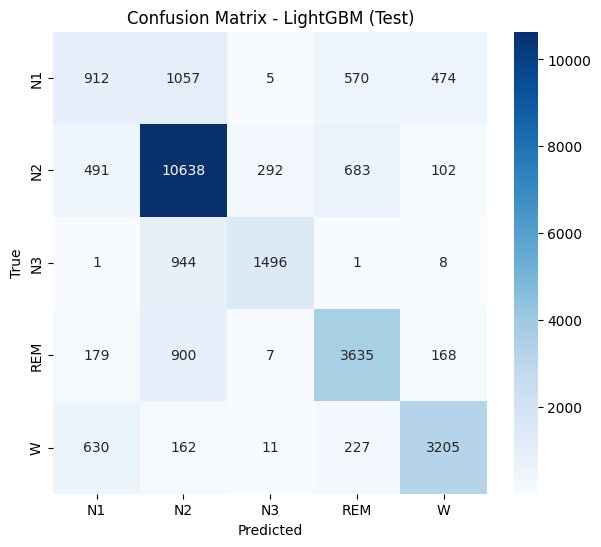

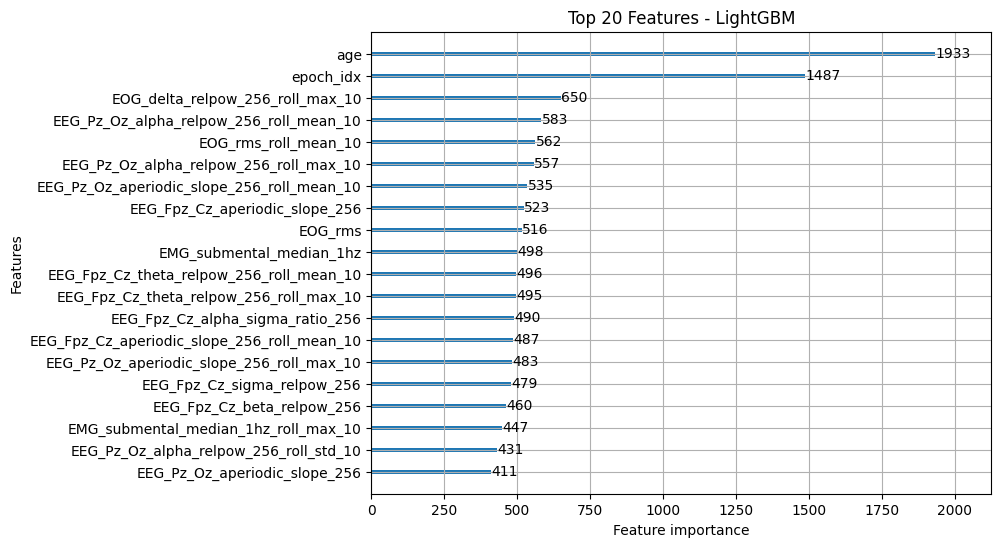

In [14]:
# ======================
# 5. Avaliação no Teste
# ======================
y_pred_proba = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)
y_pred = clf.predict(X_test)

print("\nClassification Report (Test):")
print(classification_report(y_test, y_pred, target_names=np.unique(y_train)))

# ======================
# 6. Matriz de Confusão
# ======================
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_train))
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_train),
            yticklabels=np.unique(y_train))
plt.title("Confusion Matrix - LightGBM (Test)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ======================
# 7. Importância das Features
# ======================
lgb.plot_importance(clf, max_num_features=20, figsize=(8,6))
plt.title("Top 20 Features - LightGBM")
plt.show()